In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from pylab import *
import itertools as itl
from sklearn.metrics import confusion_matrix
from PlotUtils import *
from utils import read_json
import pathlib
# from datasets import ObjectDetectionDataSet
# from transformations import Clip, ComposeDouble, FunctionWrapperDouble, normalize_01
from utils import get_filenames_of_path, read_json

import glob
import os
from tqdm import tqdm
# import cv2
from PIL import Image

def LabelCardinality(cLabs):
    if type(cLabs) == type(np.array([1])):
        pass
    else:
        cLabs = np.array(cLabs)
    LC = (1/len(cLabs))  * sum(cLabs)
    return LC
def LabelDensity(cLabs, q):
    if type(cLabs) == type(np.array([1])):
        pass
    else:
        cLabs = np.array(cLabs)
    LC = (1/len(cLabs))  * sum(cLabs/q)
    return LC


# Cambiar el tamaño de la letra
# plt.rcParams.update({'font.size': 22})
# Para cambiar el mapa de color por defecto
plt.rcParams["image.cmap"] = "Set2"
# Para cambiar el ciclo de color por defecto en Matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#8C6D31', '#ffdd6b', '#e9e2c9', '#dcae52', '#af7132', '#8C9363', '#637939', '#AD494A', '#E7969C', '#C4CBB9'])
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4', '#edf8b1', '#ffffd9'])
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#084081', '#0868ac', '#2b8cbe', '#4eb3d3', '#7bccc4', '#a8ddb5', '#ccebc5', '#e0f3db', '#f7fcf0'])
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac','#053061'])
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#67001f', '#053061', '#b2182b', '#2166ac', '#d6604d', '#4393c3', '#f4a582', '#92c5de', '#fddbc7','#d1e5f0'])
#plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#67001f', '#053061', '#b2182b', '#2166ac', '#d6604d', '#4393c3', '#f4a582', '#92c5de', '#fddbc7','#d1e5f0'][::-1])
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9','#bc80bd','#ccebc5','#ffed6f'])
# plt.rcParams["axes.prop_cycle"] =  plt.cycler('color', ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9','#bc80bd','#ccebc5','#ffed6f'][::-1])
Set_ColorsIn(plt.cm.Set2.colors)
#Set_ColorsIn(['#67001f', '#053061', '#b2182b', '#2166ac', '#d6604d', '#4393c3', '#f4a582', '#92c5de', '#fddbc7','#d1e5f0'][::-1])

# Cambiar el tipo de letra
# plt.rcParams.update({'text.latex.preamble': r'\usepackage{nimbusserif}',
#                      'text.usetex': True,
#                      'font.family': 'serif',
#                      'font.serif': ['Nimbus Roman No9 L'],
#                      'font.size': 16,})
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

# plt.rc('font',**{'family':'serif','serif':['Computer Modern']})
# plt.rc('text', usetex=True)
# # plt.rcParams['text.latex.preamble'] = [r'\boldmath']

c:\Users\mario\anaconda3\envs\AppleDis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
AD = pd.read_csv('Data/train.csv')
images = AD['image']
labels = AD['labels']

In [4]:
# Total images, pathologies and pathologies per image
print('Total images: {}'.format(len(images)))
TAL = list(itl.chain(*[label.split(' ') for label in labels]))
print('Total assigned labels: {}'.format(len(TAL)))

# Unique labels
UL = list(set(TAL))
print('Number of unique labels: {}'.format(len(UL)))

# Pathologies per image
LPI = [len(label.split(' ')) for label in labels]
NLPI = pd.Series(LPI).value_counts() 
print('\nDistribution of the number of labels per image: ')
print(NLPI)

# Healthy vs. At least 1 disease cases
print('\nHealthy cases: {}'.format(sum(labels == 'healthy')))
print('Cases with at least 1 disease: {}'.format(sum(labels != 'healthy')))

# Labels Cardinality and Density
# Cadinality: is a measure of labels distribution per example. It is defined as the mean number of labels associated with an example.
# Density: indicates the frequency of the labels among all the instances
q  = len(set(TAL))
print('\nLabels cardinality: {:.2f}'.format(LabelCardinality(LPI)))
print('Labels density: {:.2f}'.format(LabelDensity(LPI, q)))
print('Number of different label sets:', len(labels.unique()))


Total images: 18632
Total assigned labels: 20187
Number of unique labels: 6

Distribution of the number of labels per image: 
1    17277
2     1155
3      200
dtype: int64

Healthy cases: 4624
Cases with at least 1 disease: 14008

Labels cardinality: 1.08
Labels density: 0.18
Number of different label sets: 12


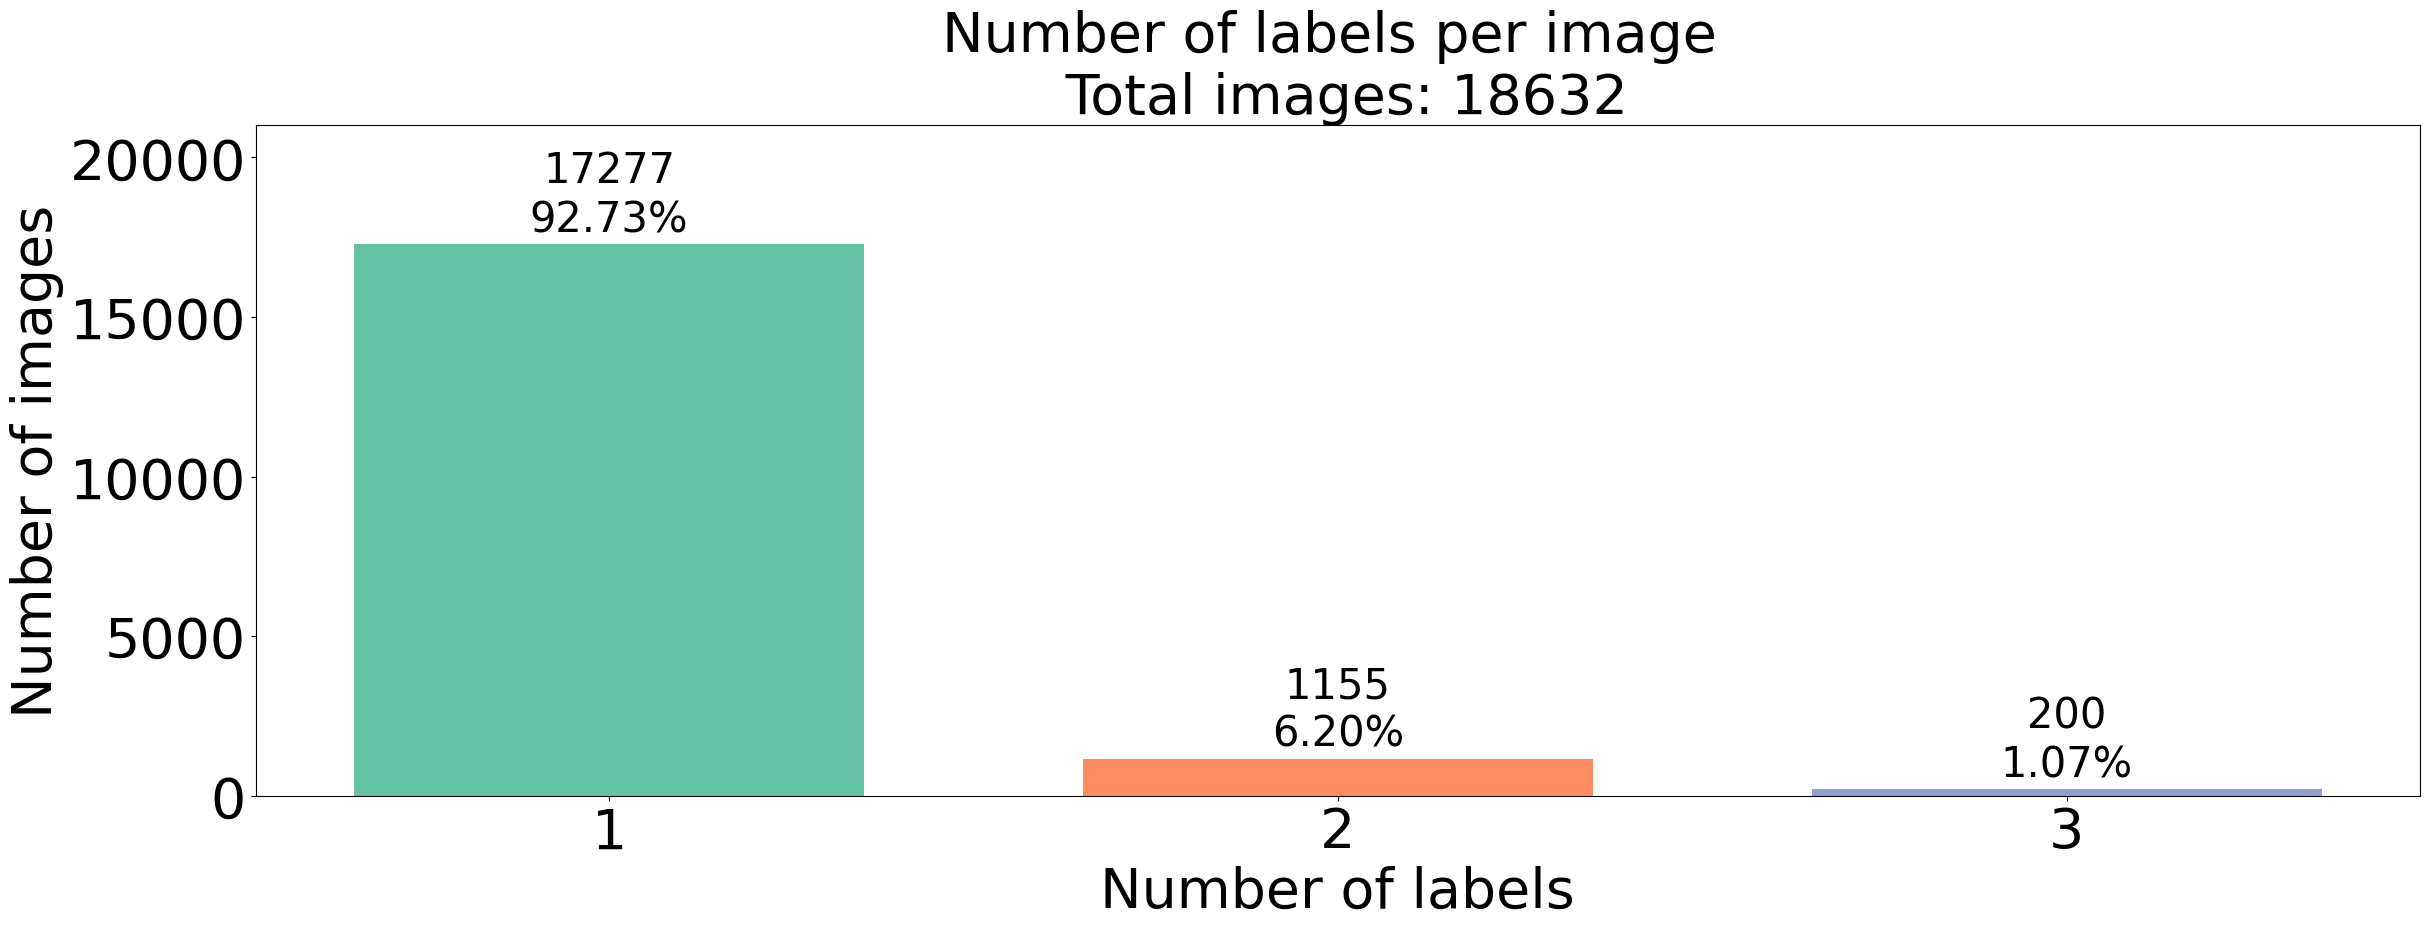

In [5]:
NLPInorm = [e/sum(NLPI) for e in NLPI]
data = {'# labels per image': NLPI}
labs = ['{}'.format(i+1) if i+1 == 1 else '{}'.format(i+1) for i in range(len(NLPI))]
title =  'Number of labels per image \n Total images: {}'.format(len(images))
groupedBarPlot(data,labs,title, width= 0.7, legend = False,figsize=(25,10), barLabel=['{}\n{:.2f}%',[n*100 for n in NLPInorm]],fsizes = {'axes':40,'xtick':40, 'ytick':40, 'font':30}, axisLim = {'ylim':[0,21000]},axislabels=['Number of labels','Number of images'])#, png = 'Figures/ChestX-ray8/Color2Fin/PNGs/PxM', pdf = 'Figures/ChestX-ray8/Color2Fin/PDFs/PxM')

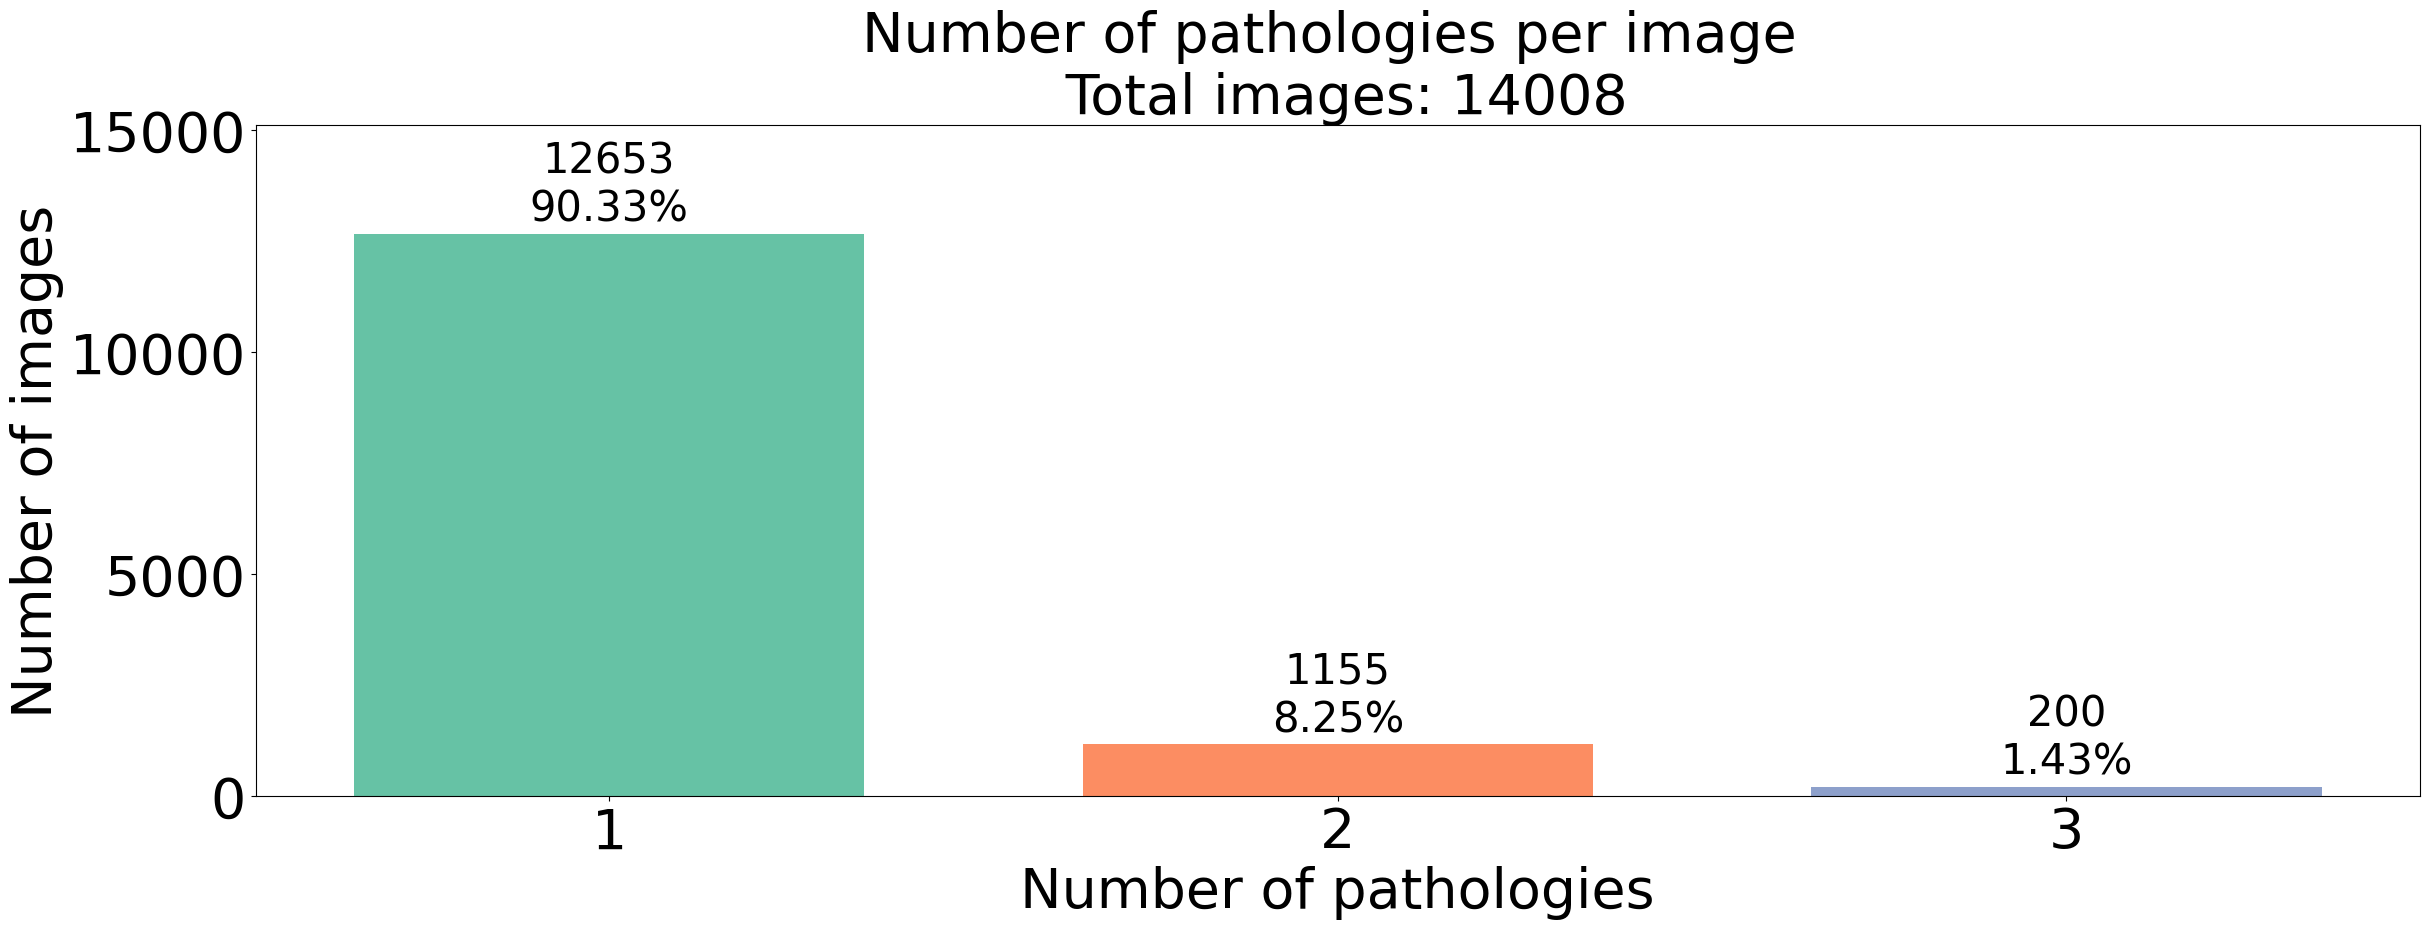

In [7]:
paths = labels[labels != 'healthy']
PPI = [len(path.split(' ')) for path in paths]
NPPI = pd.Series(PPI).value_counts() 
NPPInorm = [e/sum(NPPI) for e in NPPI]
data = {'# pathologies per image': NPPI}
labs = ['{}'.format(i+1) if i+1 == 1 else '{}'.format(i+1) for i in range(len(NPPI))]
title =  'Number of pathologies per image \n Total images: {}'.format(len(paths))
groupedBarPlot(data,labs,title, width= 0.7, legend = False,figsize=(25,10), barLabel=['{}\n{:.2f}%',[n*100 for n in NPPInorm]],fsizes = {'axes':40,'xtick':40, 'ytick':40, 'font':30}, axisLim = {'ylim':[0,15100]},axislabels=['Number of pathologies','Number of images'])#, png = 'Figures/ChestX-ray8/Color2Fin/PNGs/PxM', pdf = 'Figures/ChestX-ray8/Color2Fin/PDFs/PxM')

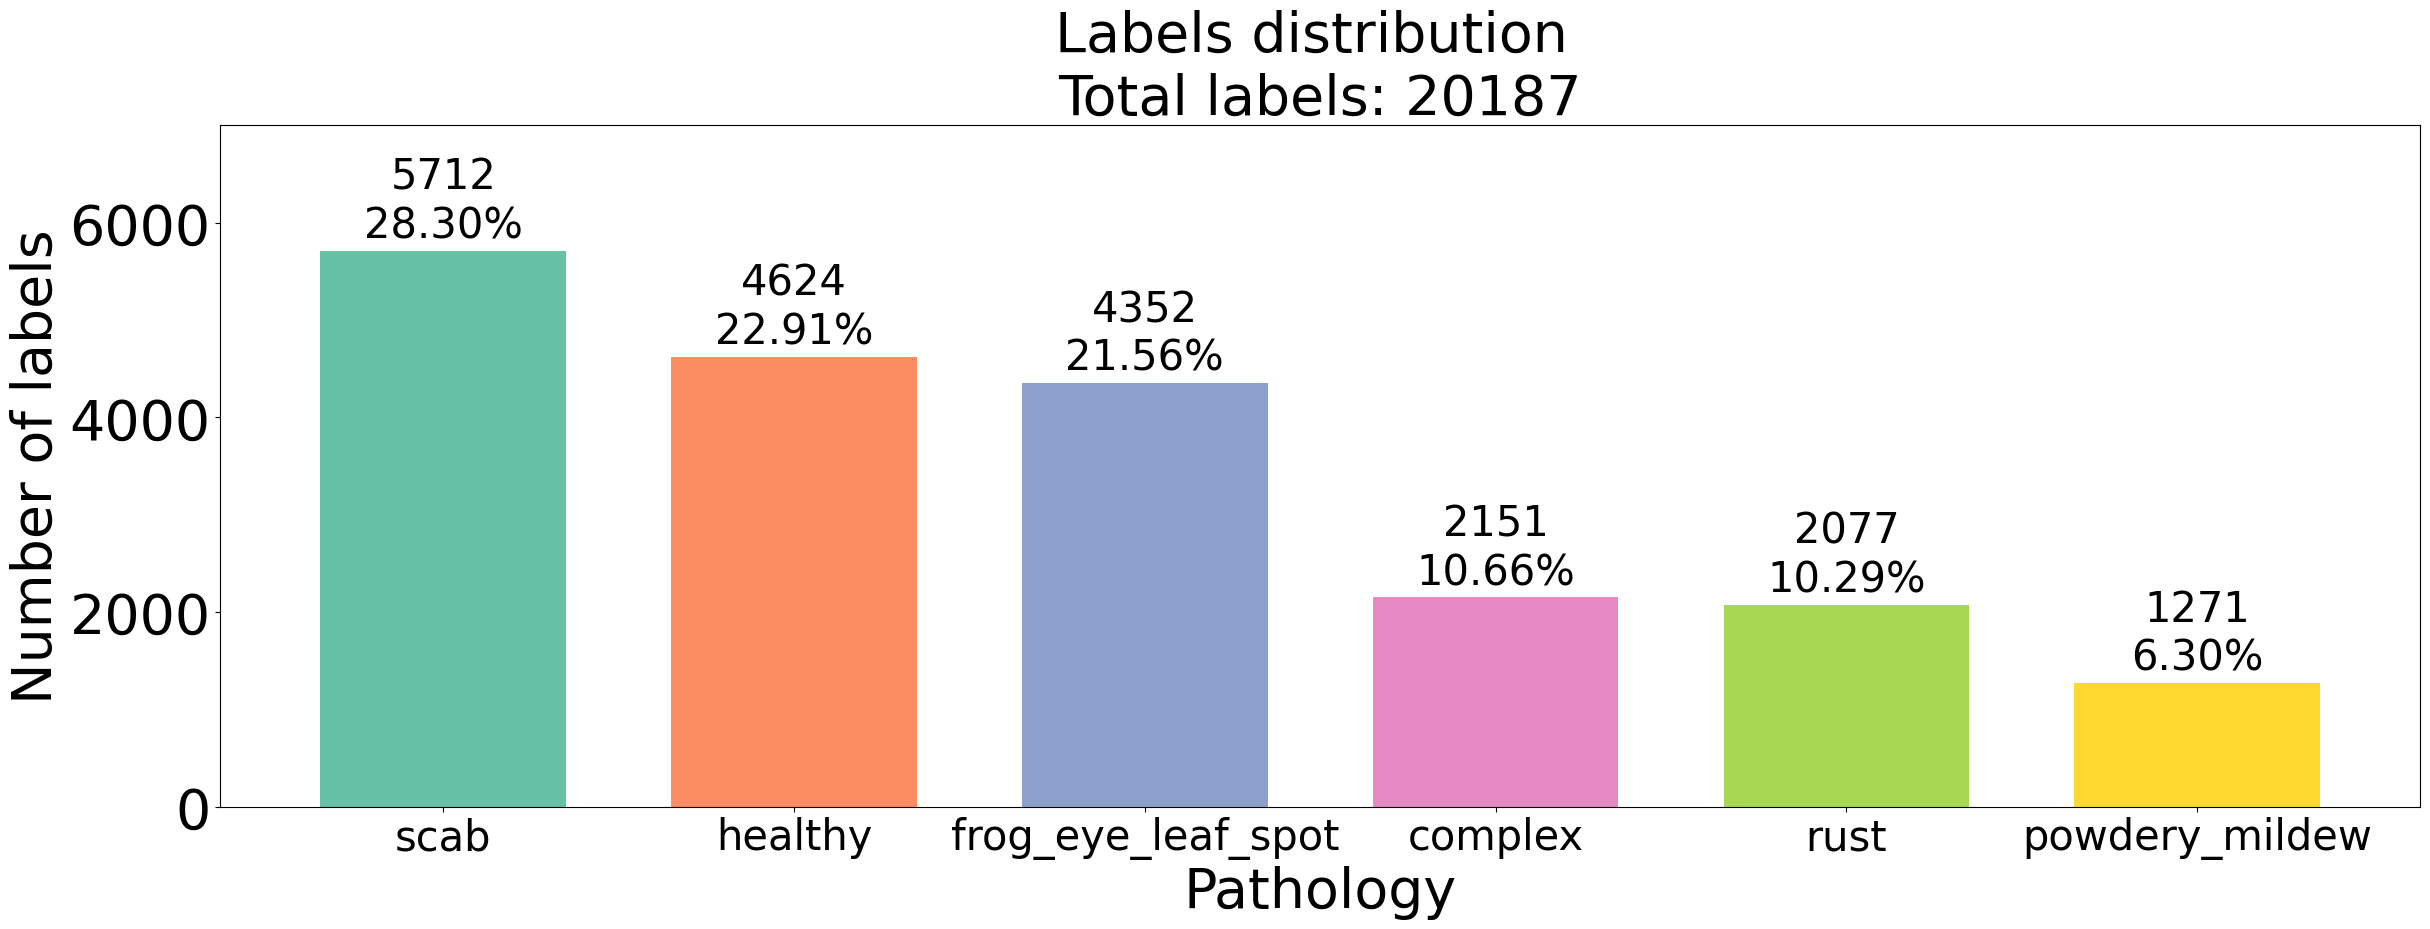

In [8]:
# Labels distribution
LD =  pd.Series(TAL).value_counts()
LDnorm = [e/sum(LD) for e in LD]
data = {'Labels distribution': LD}
labs = ['{}'.format(i) for i in LD.index]
title =  'Labels distribution \nTotal labels: {}'.format(len(TAL))
groupedBarPlot(data,labs,title, width= 0.7, legend = False,figsize=(25,10), barLabel=['{}\n{:.2f}%',[n*100 for n in LDnorm]],fsizes = {'axes':40,'xtick':30, 'ytick':40, 'font':30}, axisLim = {'ylim':[0,7000]},axislabels=['Pathology','Number of labels'])#, png = 'Figures/ChestX-ray8/Color2Fin/PNGs/PxM', pdf = 'Figures/ChestX-ray8/Color2Fin/PDFs/PxM')

In [9]:
ccmprep = {k:np.zeros([len(labels)], dtype=int) for k in UL}

for lab in labels.index:
    dis = labels[lab].split(' ')
    for j in dis:
        ccmprep[j][lab]=1 
CCM = pd.DataFrame(ccmprep)
CCM

scab  complex  healthy  powdery_mildew  rust  frog_eye_leaf_spot
0         0        0        1               0     0                   0
1         1        1        0               0     0                   1
2         1        0        0               0     0                   0
3         1        0        0               0     0                   0
4         0        1        0               0     0                   0
...     ...      ...      ...             ...   ...                 ...
18627     0        0        1               0     0                   0
18628     1        0        0               0     0                   0
18629     0        0        0               0     1                   0
18630     1        0        0               0     0                   1
18631     0        0        1               0     0                   0

[18632 rows x 6 columns]

In [10]:
coocc = CCM.T.dot(CCM)
coocc

scab  complex  healthy  powdery_mildew  rust  \
scab                5712      200        0               0     0   
complex              200     2151        0              87    97   
healthy                0        0     4624               0     0   
powdery_mildew         0       87        0            1271     0   
rust                   0       97        0               0  2077   
frog_eye_leaf_spot   886      365        0               0   120   

                    frog_eye_leaf_spot  
scab                               886  
complex                            365  
healthy                              0  
powdery_mildew                       0  
rust                               120  
frog_eye_leaf_spot                4352

C:\Users\mario\AppData\Local\Temp\ipykernel_41480\353531397.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_rainbow', 6)


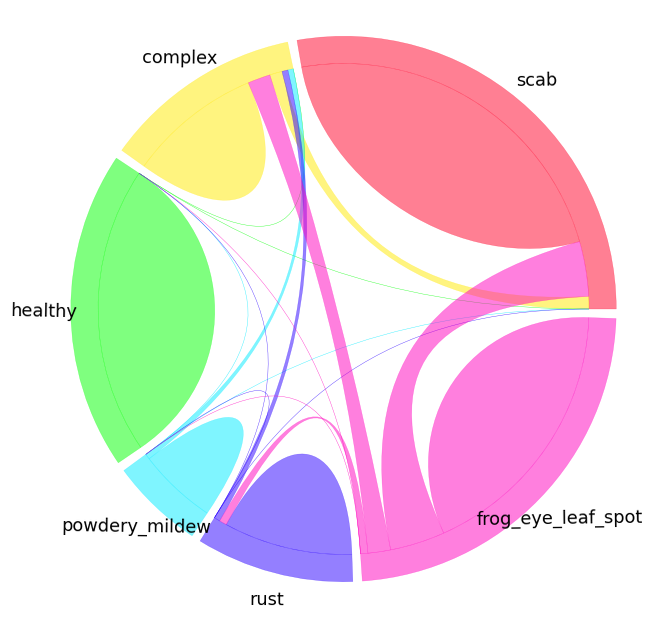

In [12]:
fig = plt.figure(figsize=(6,6))
flux = coocc.to_numpy()[:6,:6]

ax = plt.axes([0,0,1,1])
cmap = cm.get_cmap('gist_rainbow', 6)  
crgb =  [cmap(i)[:3] for i in range(cmap.N)]
#nodePos = chordDiagram(flux, ax, colors=[hex2rgb(x) for x in ['#666666', '#66ff66', '#ff6666', '#6666ff']])
nodePos = chordDiagram(flux, ax, colors = crgb)
ax.axis('off')
prop = dict(fontsize=16*0.8, ha='center', va='center')
nodes = UL
for i in range(len(nodes)):
    ax.text(nodePos[i][0], nodePos[i][1], nodes[i], rotation=nodePos[i][0], **prop)

ax.patch.set_alpha(0.0)
# plt.savefig('Figures/ChestX-ray8/Color2/PNGs/DCuerdas.png', transparent=True, bbox_inches='tight')
# plt.savefig('Figures/ChestX-ray8/Color2/PDFs/DCuerdas.pdf', transparent=True, bbox_inches='tight')
#     # plt.savefig("example.png", dpi=600,
# #         transparent=True,
# #         bbox_inches='tight', pad_inches=0.02)

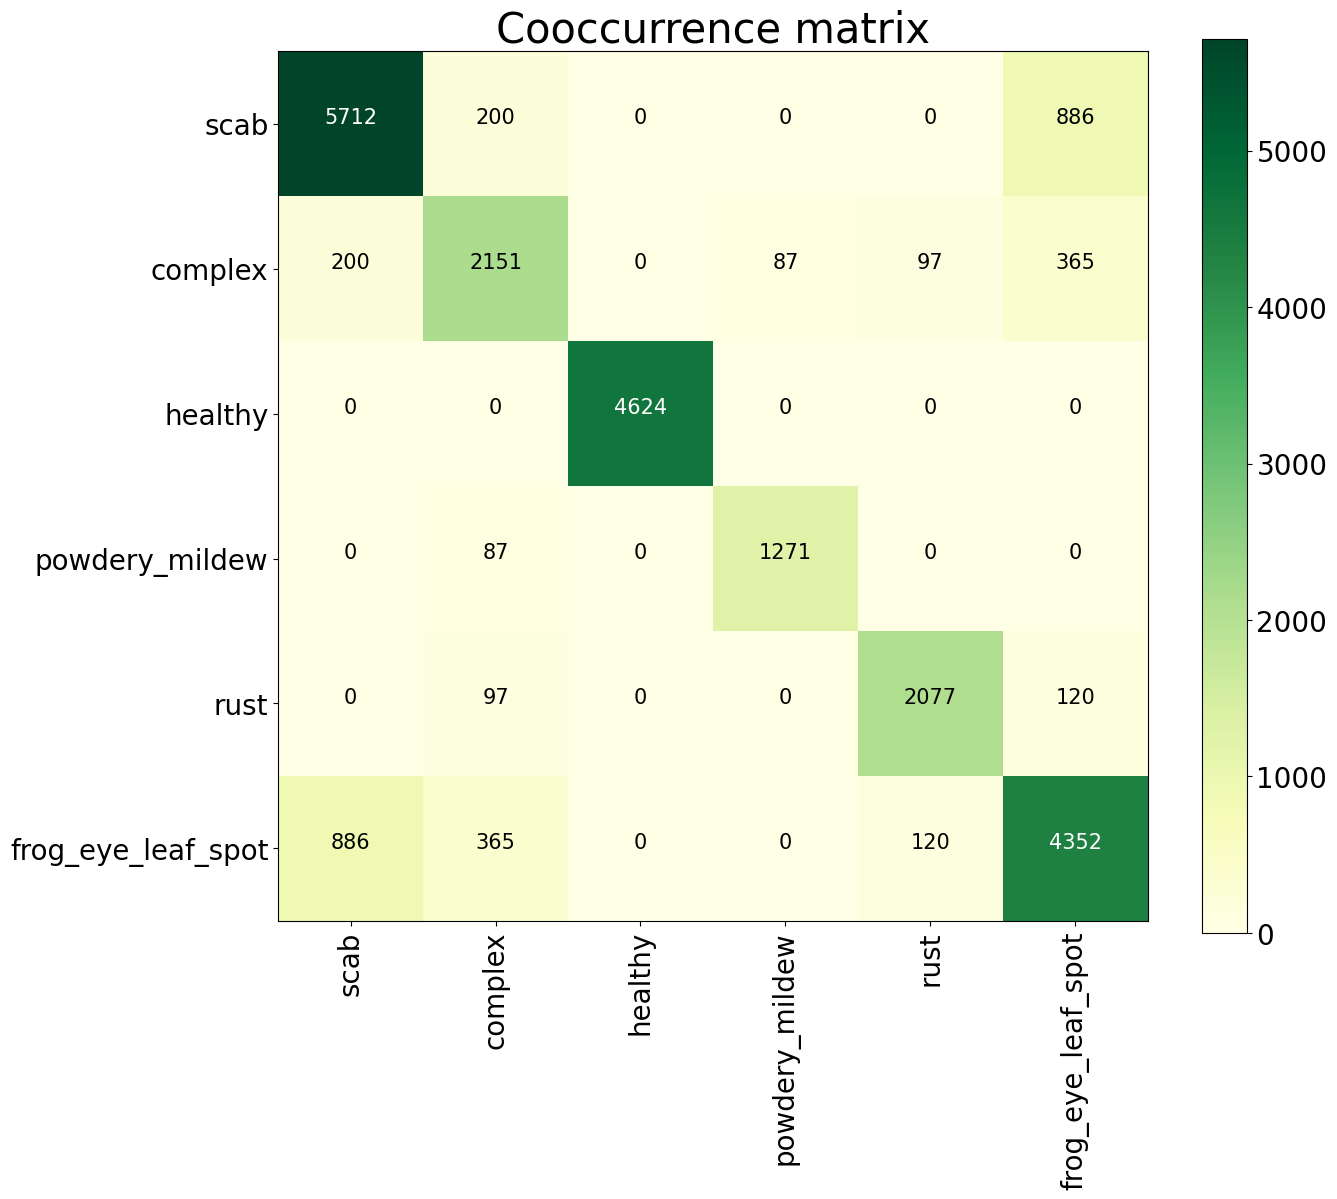

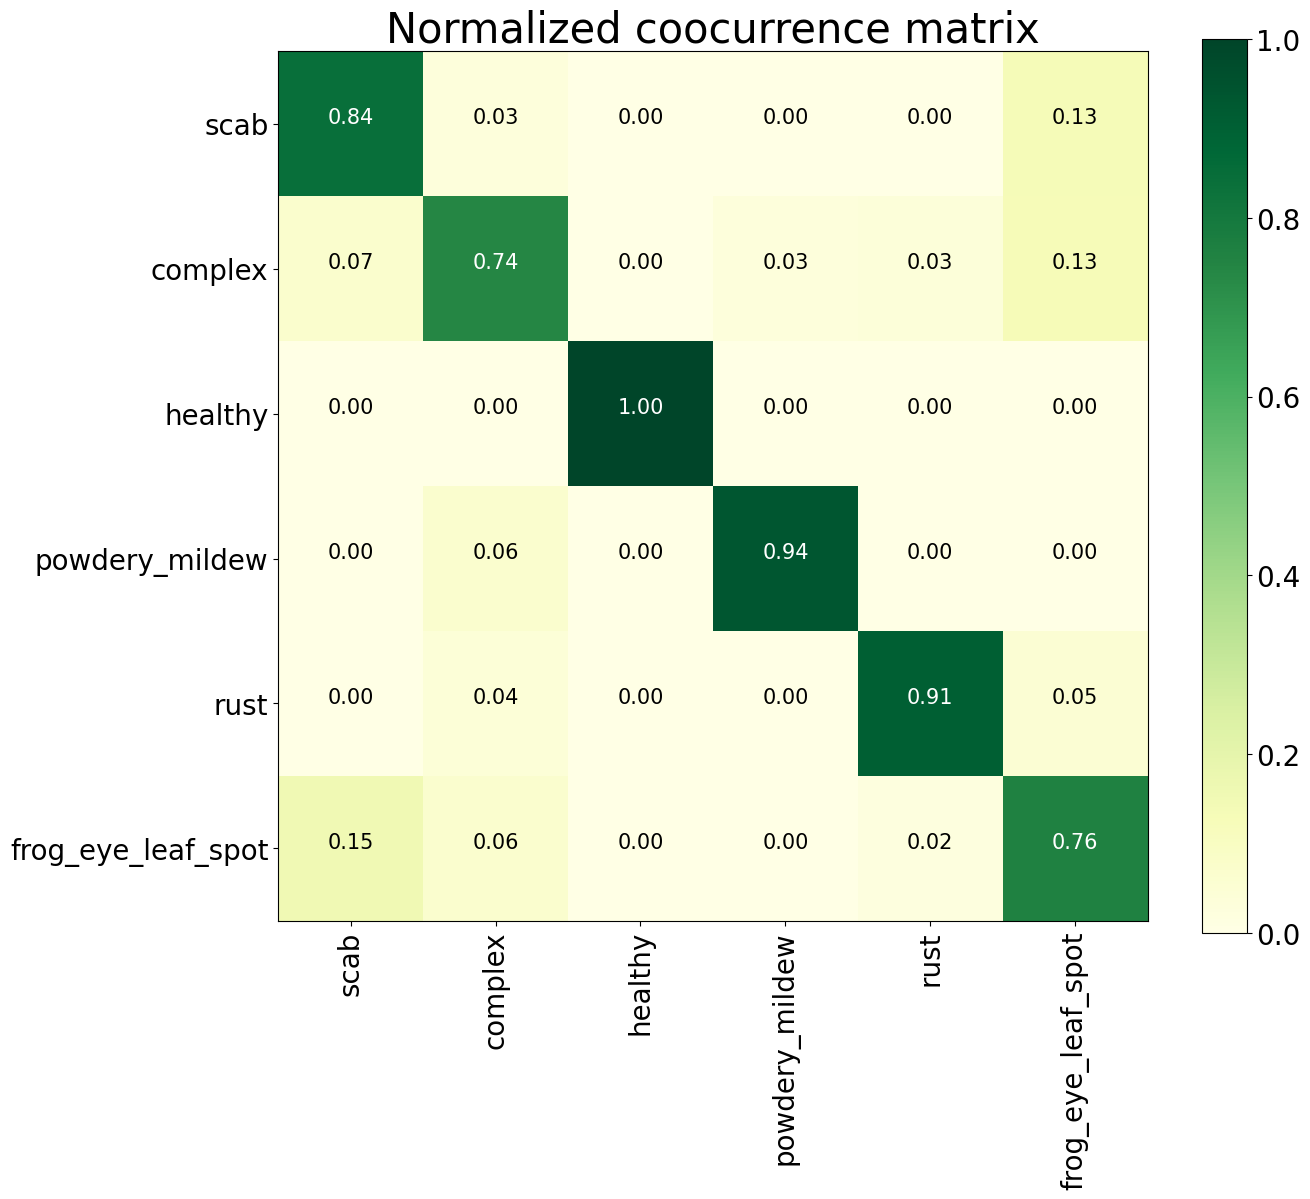

In [13]:
objects = UL
plot_confusion_matrix(coocc.to_numpy(), classes=objects, normalize=False, colors = plt.cm.YlGn, tit = 'Cooccurrence matrix', axisLabels = ['',''], fsizes = {'font':15,'axes':30,'xtick':20, 'ytick':20}, xtickRot=90)#, png = 'Figures/ChestX-ray8/Color2/PNGs/CMNN', pdf = 'Figures/ChestX-ray8/Color2/PDFs/CMNN')
plot_confusion_matrix(coocc.to_numpy(), classes=objects, normalize=True, colors = plt.cm.YlGn, tit = 'Normalized coocurrence matrix', axisLabels = ['',''], fsizes = {'font':15,'axes':30,'xtick':20, 'ytick':20}, xtickRot=90)#, png = 'Figures/ChestX-ray8/Color2/PNGs/CMN', pdf = 'Figures/ChestX-ray8/Color2/PDFs/CMN')

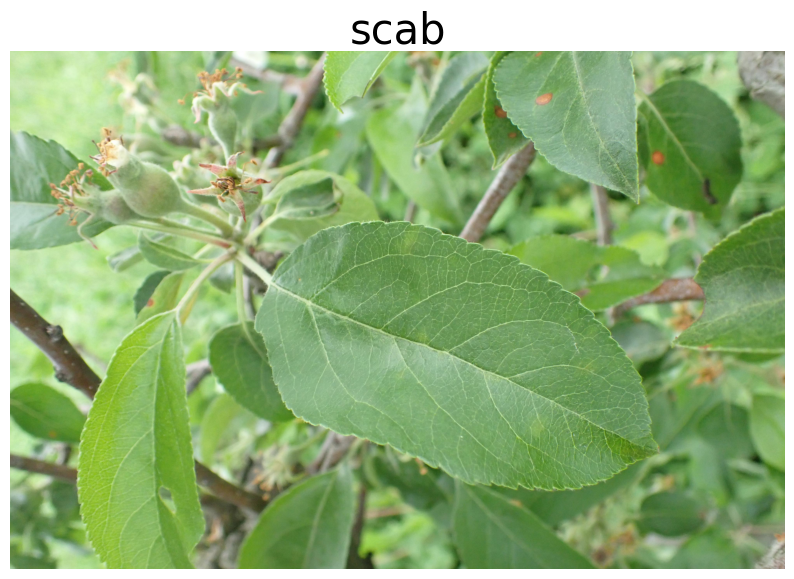

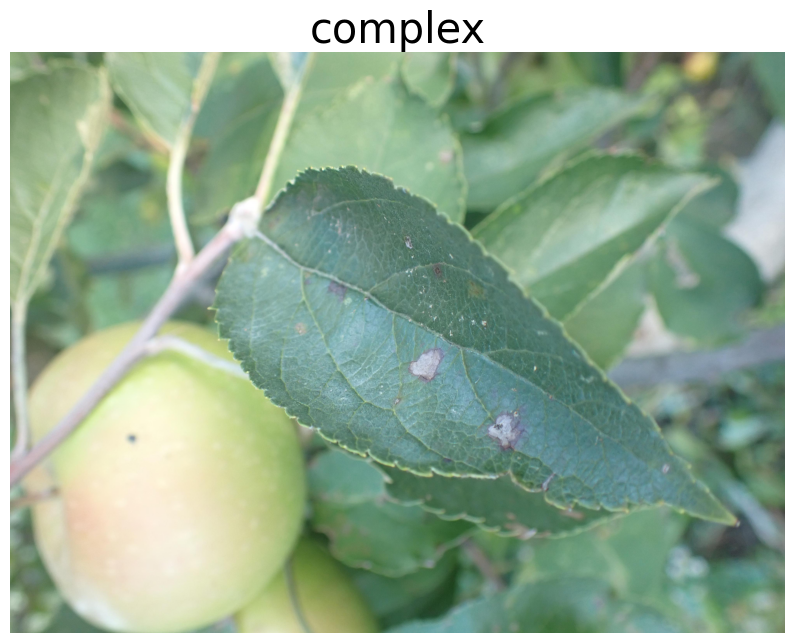

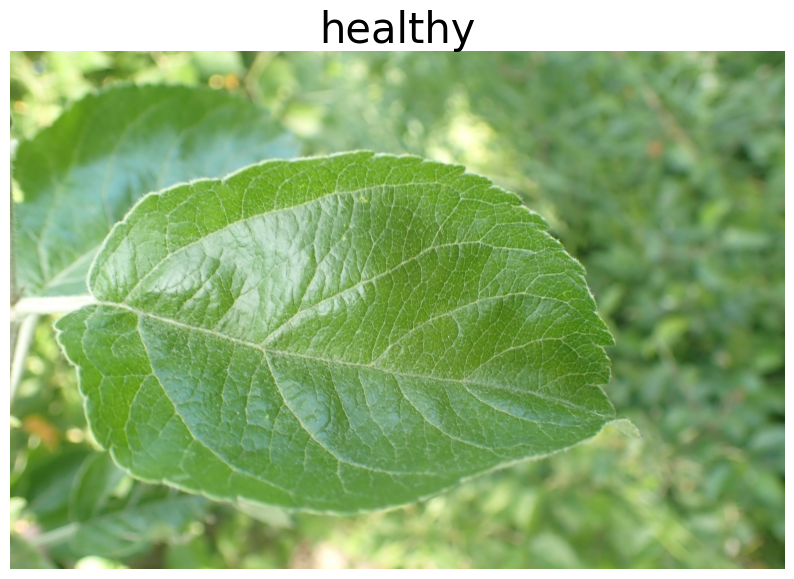

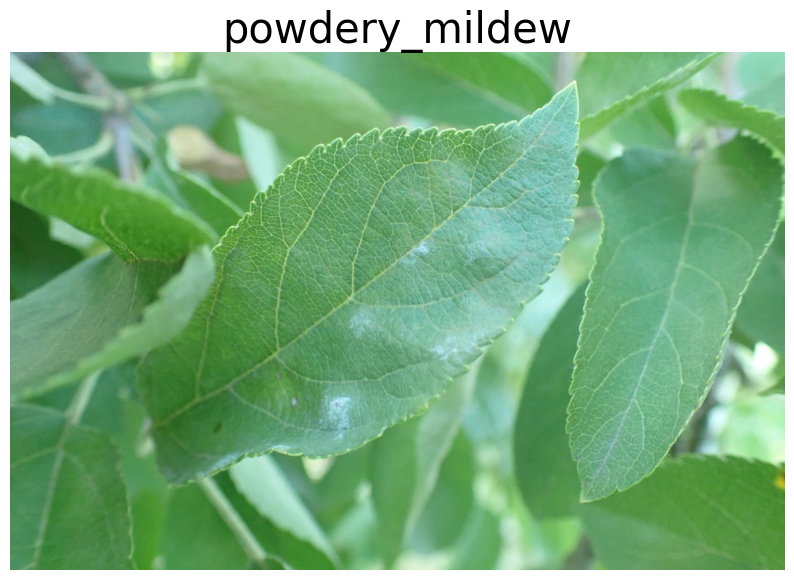

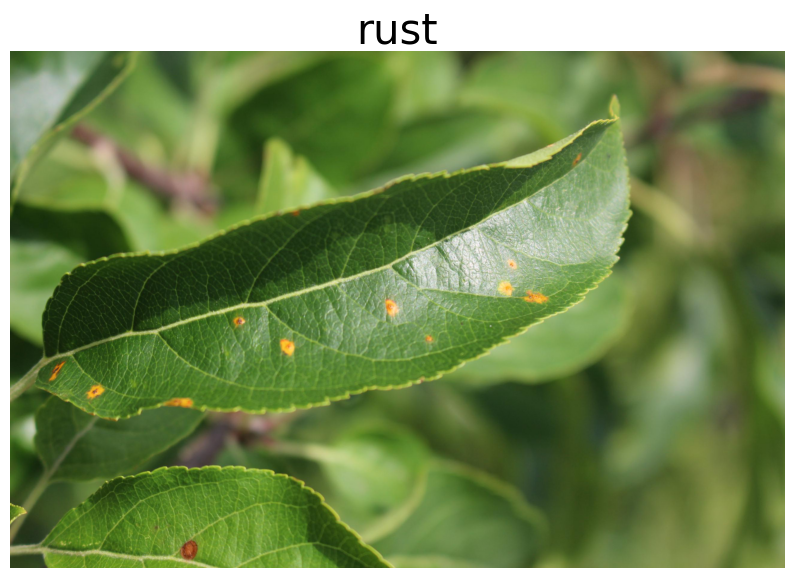

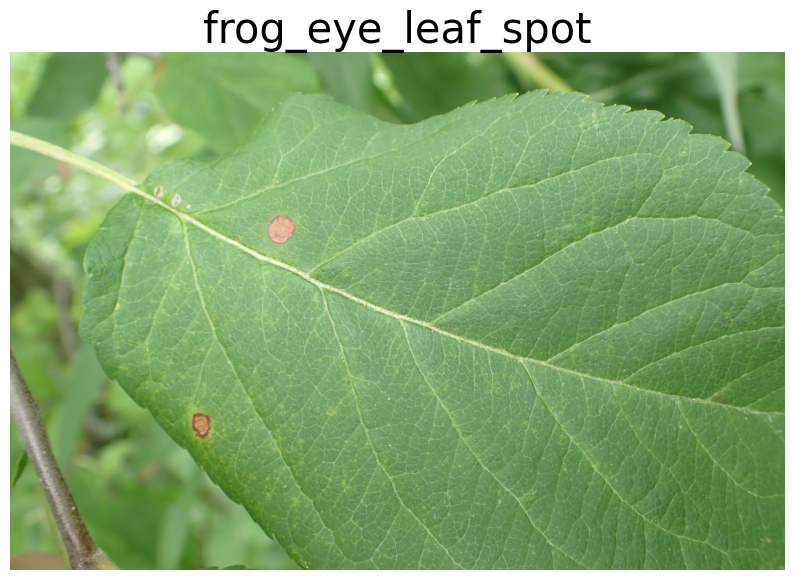

In [41]:
# Instances visualizations
EI = []
for e in UL: 
    ins = AD[labels == e].sample(1)
    figure, ax = plt.subplots(1,figsize=[10,10])
    ax.imshow(plt.imread('Data/train_images/'+ins['image'].values[0]))
    plt.axis('off')
    plt.title(ins['labels'].values[0])